In [1]:
# https://stackoverflow.com/questions/37159070/multiple-linear-regression-model-by-using-tensorflow
# https://donaldpinckney.com/books/pytorch/book/ch2-linreg/2018-03-21-multi-variable.html
# https://www.youtube.com/watch?v=Q4GNLhRtZNc
# https://atmamani.github.io/projects/ml/coursera-gd-multivariate-linear-regression/

# Multivariable Linear Regression using frequency data (converted from time series)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import exp

plt.rcParams['figure.figsize'] = [16,12]
plt.rcParams.update({'font.size': 18})

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#generate x-axis for time series based on 30-minute intervals
def get_time_axis(moments):
    x_axis = np.zeros((moments,))
    for col in range(moments):
        x_axis[col] = 30*col #30 minute intervals per day (80 day period)
    return x_axis

In [3]:
#normalize X values to help model converge
def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std
    return data

In [4]:
#Logistic Layer using a sigmoid function
def logistic_layer(y):
    y = np.array(y)
    y = 1 / (1 + exp(-y)) # sigmoid function
    y = y.ravel()
    return y

In [5]:
#Calculate an accuracy metric
def accuracy(predicted_y, true_y):
    true_y = np.array(true_y).ravel()
    counter = 0
    for i in range(len(true_y)):
        p_y = predicted_y[i]
        t_y = true_y[i]
        if (p_y>.5 and t_y == 1) or (p_y < .5 and t_y == 0):
            counter+=1
    counter = (counter/ len(true_y)) * 100
    return counter

In [6]:
#split training data
data = np.matrix(pd.read_csv("../archive/exoTrain.csv").values)
training_data_y = data[:,0]
training_data_y-=1

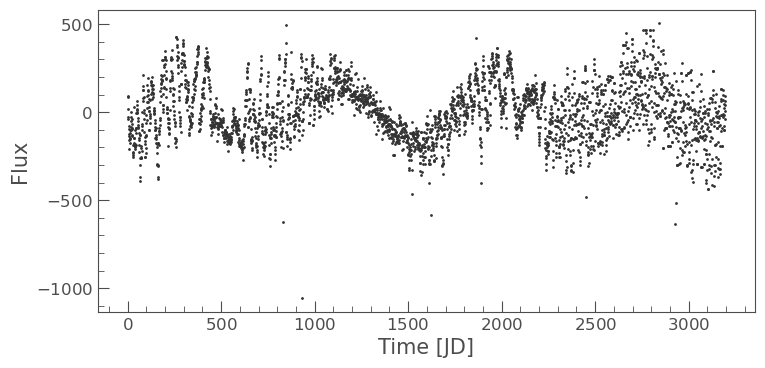

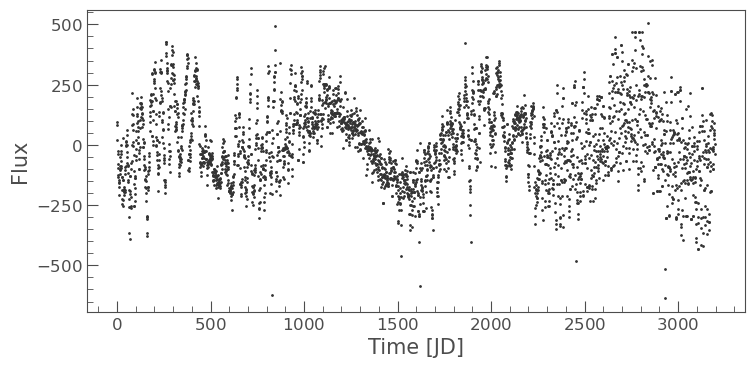

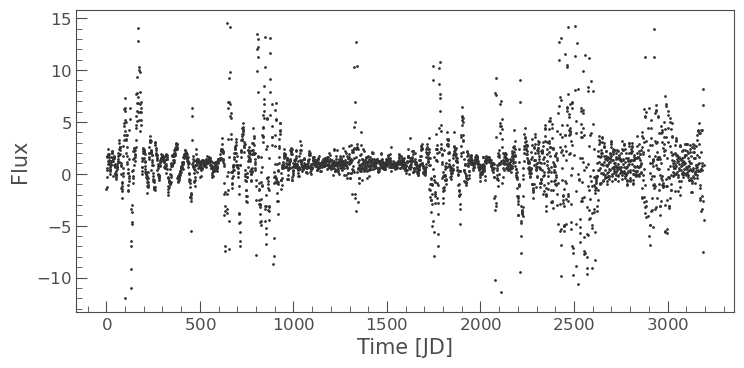

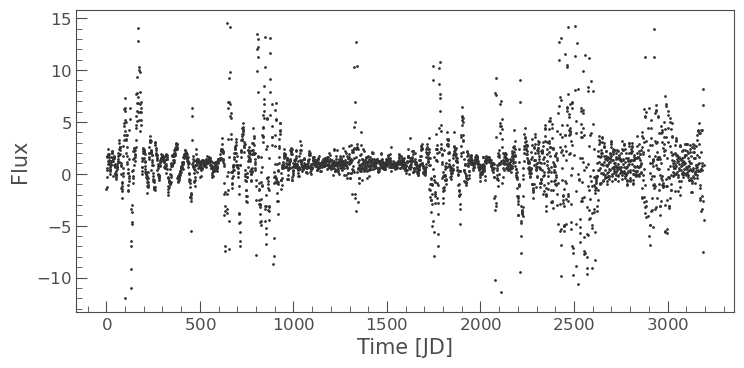

In [20]:
import lightkurve as lk

training_data_x = np.zeros(shape=(len(data),3102))
for i in range(0,len(training_data_x)):
    lc = lk.LightCurve(time=range(0,3197), flux=np.array(data[i,1:]).flatten())
    lc.scatter()
    lc = lc.remove_outliers()
    lc.scatter()
    lc = lc.flatten().remove_outliers()
    lc.scatter()
    #period = lc.to_periodogram("bls", frequency_factor= 1000).period_at_max_power
    #lc = lc.fold(period)
    lc.scatter()
    training_data_x[i, :] = lc.flux
    break

Text(0.5, 0, 'Frequency')

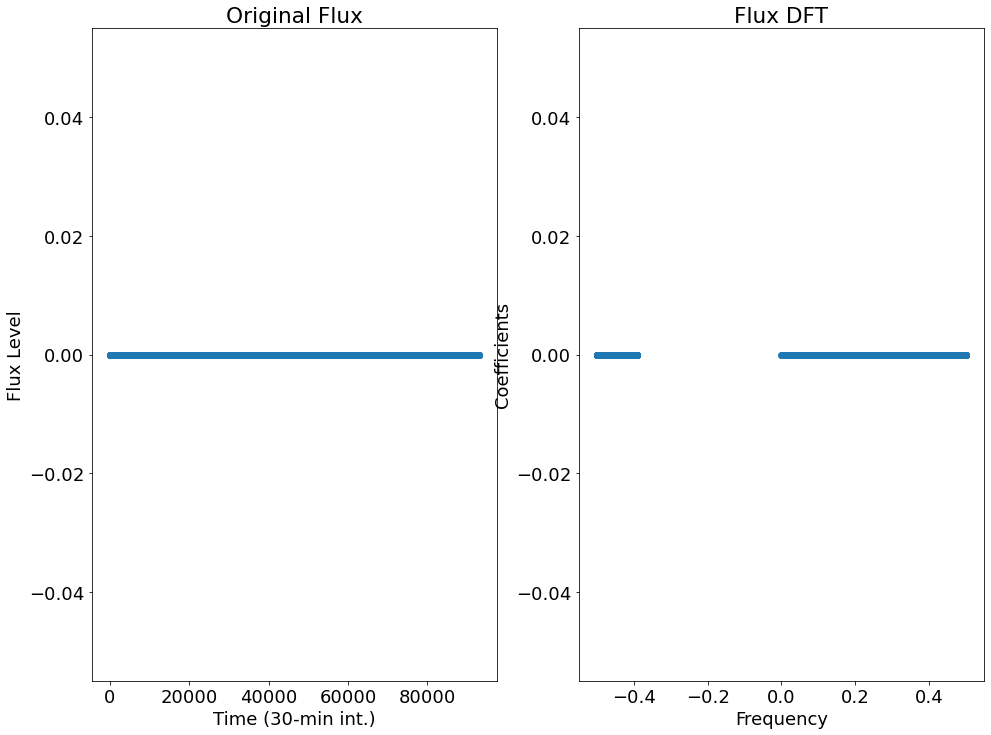

In [21]:
fig,axs = plt.subplots(1,2)
plt.sca(axs[0])
plt.plot(get_time_axis(3101), training_data_x[1,0:3101].transpose(), 'o')
plt.title("Original Flux")
plt.ylabel("Flux Level")
plt.xlabel("Time (30-min int.)")

#convert to frequencies using fft algorithm
training_data_x_fft = np.fft.fft(training_data_x).real
freq = np.fft.fftfreq(len(training_data_x))
plt.sca(axs[1])
plt.plot(freq[0:3101], training_data_x_fft[1,0:3101].transpose(), 'o')
plt.title("Flux DFT")
plt.ylabel("Coefficients")
plt.xlabel("Frequency")

In [ ]:
fig,axs = plt.subplots(1,3)

PSD = training_data_x_fft * np.conj(training_data_x_fft)/len(freq)
plt.sca(axs[0])
plt.plot(freq[0:150], PSD[34:37,0:150].transpose(), 'o')
plt.title("Power Spectrum Density")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

#normalize using log transform
PSD_log = np.log(PSD)
plt.sca(axs[1])
plt.plot(freq[0:150], PSD_log[34:37,0:150].transpose(), 'o')
plt.title("Log Transform")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

#normalize using z score
PSD_norm = normalize(PSD.transpose())
plt.sca(axs[2])
plt.plot(freq[0:150], PSD_norm[34:37,0:150].transpose(), 'o')
plt.title("Z transform")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

In [ ]:
training_data_x = PSD_norm
training_data_y = training_data_y.transpose()

#set hyperparameters & variables
learning_rate = 0.001
epochs = 100
display_step = 5
n_samples = training_data_x.shape[1]
col_num = training_data_x.shape[0]

X = tf.placeholder(tf.float32, [col_num, n_samples])
Y = tf.placeholder(tf.float32, [1, n_samples])

# We want the weight vector to correspond one to one with every column
W = tf.Variable(tf.zeros([1,col_num], dtype=np.float32), name="weight")
b = tf.Variable(tf.zeros([1, ], dtype=np.float32), name="bias")

pred = tf.matmul(W, X) + b
error = tf.reduce_sum((pred-Y)**2) / (n_samples * 2) #MSE

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)

session = tf.Session()
session.run(tf.global_variables_initializer())

loss_arr = []
acc_arr = []

for t in range(epochs):
    
    _, current_loss, current_W, current_b = session.run([optimizer, error, W, b], feed_dict={
        X: training_data_x,
        Y: training_data_y
    })

    if t % display_step == 0:
        print("t = %g, loss = %g, W = %s, b = %g" % (t, current_loss, str(current_W), current_b))
    loss_arr.append(current_loss)
    probs = logistic_layer(np.matmul(current_W, training_data_x) + current_b)
    acc_arr.append(accuracy(probs,training_data_y))
    
print("Optimization Finished!")

training_error = session.run(error, feed_dict={X: training_data_x, Y: training_data_y})
print("Training error=", training_error, "W=", session.run(W), "b=", session.run(b), '\n')


In [ ]:
test_data = np.matrix(pd.read_csv("../archive/exoTest.csv").values)
test_data_fft = np.fft.fft(test_data[:,1:]).real
test_freq = np.fft.fftfreq(len(test_data_fft))
test_PSD = test_data_fft * np.conj(test_data_fft)/len(test_freq)

test_x = normalize(test_PSD.transpose())
test_y = test_data[:, 0].transpose()
test_y -=1

#accuracy data
predicted_y = np.matmul(session.run(W), test_x) + session.run(b)
predicted_y = logistic_layer(predicted_y)

print("Accuracy percentage: ", accuracy(predicted_y, test_y), "%")

In [ ]:
with open('tf-models/multi-lr-dft.npy', 'wb') as f:
    np.save(f, session.run(W))
    np.save(f, session.run(b))
    np.save(f, loss_arr)
    np.save(f, acc_arr)